# Author

Daniel Soto

# Draft Status


# Introduction

This notebook creates a bar graph of the optimal, modeled, and observed SFC values.

# Method

- create generator model
- create tidy format data frame with village, sfc, sfc type 
    - apply generator model to optimal, place in data frame
    - apply generator model to observed power, place in data frame
    - calculate observed, place in data frame
- create bar graph with village on x-axis and observed as hue


# Results


# Next Work

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import WP19_analysis as wpa
import statsmodels.api as sm
import tabulate

/Users/dsoto/miniconda3/envs/wp19/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
data_zf = {}
for rfd in wpa.raw_file_data[2:]:
    vname = rfd['village_name']
    energy_data = wpa.load_timeseries_file(vname + '-clean.csv')
    messages = wpa.load_message_file(vname + '-messages.csv')
    # zero filled data
    data_zf[vname] = wpa.insert_zeros_energy(energy_data, messages)

In [4]:
# load data and add a column for the delivered load in kVA rather than a percentage

gen_data = pd.read_csv('../data_sheets/generator_data.csv', comment='#')
gen_data['load_kVA'] = gen_data['rated_power_kVA'] * gen_data['percent_load'] / 100
gen_data.head()

# iterate over each model and perform a fit and show table of results

generator_fits = []
models = gen_data['model_number'].unique()
for m in models:
    model_data = gen_data[gen_data['model_number'] == m]
    y = model_data['fuel_consumption_lph']
    X = model_data['load_kVA']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    generator_fits.append({'model': m,
                           'rated_power_kVA':model_data['rated_power_kVA'].mean(), 
                           'no_load_consumption': model.params['const'],
                           'fuel_coefficient': model.params['load_kVA'],
                           'R-squared': model.rsquared})
    
generator_fits = pd.DataFrame(generator_fits)
generator_fits

marginal_fuel_rate = generator_fits['fuel_coefficient'].mean()
no_load_fuel_rate = generator_fits['no_load_consumption'].mean()
print('marginal fuel rate (lph) =', marginal_fuel_rate)
print('no load fuel consumption (lph) =', no_load_fuel_rate)
print(generator_fits['fuel_coefficient'].std())
print(generator_fits['no_load_consumption'].std())
print(generator_fits['fuel_coefficient'].std()/generator_fits['fuel_coefficient'].mean())
print(generator_fits['no_load_consumption'].std()/generator_fits['no_load_consumption'].mean())

def get_fuel_rate(load_power=None):
    return load_power * marginal_fuel_rate + no_load_fuel_rate

def get_SFC(load_power=None, fuel_rate=None):
    return fuel_rate / load_power

marginal fuel rate (lph) = 0.256012109187
no load fuel consumption (lph) = 1.38541666667
0.0189809767414
0.642072382559
0.074140933418
0.463450742298


In [7]:
# estimate SFC for optimal and observed loads

tmp_data = []
for rfd in wpa.raw_file_data[2:]:
    vname = rfd['village_name']
    energy_data = wpa.load_timeseries_file(vname + '-clean.csv')
    kVA = energy_data['kVA sliding window Demand'].dropna().values
    kVA = kVA[kVA != 0.0]
    mean_kVA = kVA.mean()
    rated_load = rfd['genset_rating_kVA']
    SFC_100 = get_SFC(fuel_rate=get_fuel_rate(load_power=rated_load), load_power=rated_load)
    mean_load = mean_kVA
    SFC_mean = get_SFC(fuel_rate=get_fuel_rate(load_power=mean_load), load_power=mean_load)
    tmp_data.append({'Village' : vname.title(),
                     'SFC Type': 'Modeled',
                     'SFC (lpkVA)': SFC_mean,
                    })
    tmp_data.append({'Village' : vname.title(),
                     'SFC Type': 'Ideal',
                     'SFC (lpkVA)': SFC_100,
                })

for rfd in wpa.raw_file_data[2:]:
    vname = rfd['village_name']
    daily_energy = data_zf[vname]['kWh export'].diff().resample('D').sum()
    operating_daily_energy = daily_energy[daily_energy > 0]
    try:
        observed_fuel = rfd['observed_fuel_liter_per_day']
        observed_SFC = observed_fuel / operating_daily_energy.mean()
    except:
        observed_fuel = None
        observed_SFC = None
    tmp_data.append({'Village' : vname.title(),
                     'SFC (lpkVA)' : observed_SFC,
                     'SFC Type': 'Observed'})
    
data = pd.DataFrame(tmp_data)
data.pivot(index='Village', columns='SFC Type', values='SFC (lpkVA)')

SFC Type,Ideal,Modeled,Observed
Village,,,
Atamali,0.311429,0.709128,1.972002
Ayapo,0.290648,0.352735,0.666599
Kensio,0.295595,0.821159,1.644231


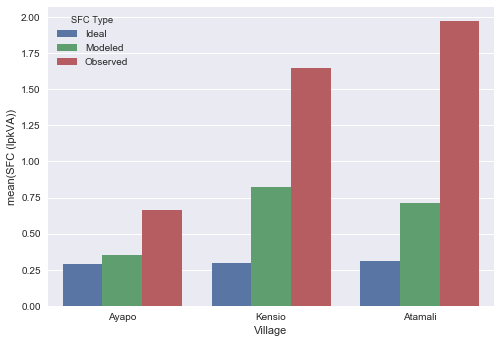

In [6]:
sns.barplot(x='Village', 
            y='SFC (lpkVA)', 
            hue='SFC Type', 
            data=data,
            hue_order=['Ideal', 'Modeled', 'Observed'],
            order=['Ayapo', 'Kensio', 'Atamali']
           )
plt.savefig('../plots/SFC-bar-graph.png')